In [1]:
from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor)
from numpy import multiply
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.util import set_random_seeds

from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal


import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
import wandb
import os
import neptune.new.integrations.sklearn as npt_utils
import neptune.new as neptune

from sklearn.datasets import make_swiss_roll
from braindecode.models import ShallowFBCSPNet, Deep4Net ,EEGNetv4,HybridNet,EEGInceptionMI,EEGITNet,ATCNet
os.environ['http_proxy'] = "http://192.41.170.23:3128"
os.environ['https_proxy'] = "http://192.41.170.23:3128"
from moabb.datasets import BNCI2014001
from moabb.paradigms import MotorImagery


In [2]:

import neptune.new as neptune
run = neptune.init_run(
    project="nutapol1997/Diffusion-probabilistic-models",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMTMyMzg0My02NzlhLTQ3N2ItYTdmMS0yNTcwNDBmM2QwM2QifQ==",
)



https://app.neptune.ai/nutapol1997/Diffusion-probabilistic-models/e/DIF-28
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [2]:

def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl

def early_stopping(train_loss, validation_loss, min_delta, tolerance):
    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

def extrack_dataset(dataset):
    for x, y, window_ind in dataset:

        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    return X,np.array(y_).T
def extrack_dataset_types(dataset,types = 'left'):
    for x, y, window_ind in dataset:

        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    y = np.array(y_).T

    if types == "left":
        X = X[y == 0]
    if types == "right":
        X = X[y == 1]
    if types == "foot":
        X = X[y == 2]
    if types == "tongue":
        X = X[y == 3]
    return X,y

def train(model,gpu_num,train_loader,test_loader,
          weights_name=False,
          optimizer = None,
          criterion = None,
          num_epochs=500,
          vail_loader= None,
          save_weights = False,
          neptune = True
         ):

    # Train the model


    train_loss = []
    valid_loss = [10,11]
    train_accuracy = []
    valid_accuracy = []

    old_loss = 100
    old_acc = 0
    valid_loss_vail = []


    for epoch in range(num_epochs):
        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()

        for i, (items, classes) in enumerate(train_loader):
            items = Variable(items)
            classes = classes.type(torch.LongTensor)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)

            optimizer.zero_grad()
            outputs = model(items)

            loss = criterion(outputs, classes)

            iter_loss += loss.item()
            loss.backward()
            optimizer.step()

            metrics = {"train/train_loss": loss}

            #print(loss)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations += 1

        train_loss.append(iter_loss/iterations)


        train_accuracy.append(( correct.float() / len(train_loader.dataset)))
        train_metrics = {"train/train_loss": iter_loss/iterations,
                       "train/train_accuracy": (100 * correct.float() / len(train_loader.dataset))}



        loss = 0.0
        correct = 0
        iterations = 0
        model.eval()

        for i, (items, classes) in enumerate(test_loader):
            classes = classes.type(torch.LongTensor)
            items = Variable(items)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)


            outputs = model(items)
            loss += criterion(outputs, classes).item()

            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == classes.data).sum()
            #print("correct : {}".format(classes.data))
            #print("predicted : {}".format(predicted))
            iterations += 1

        valid_loss.append(loss/iterations)
        correct_scalar = np.array([correct.clone().cpu()])[0]
        valid_accuracy.append(correct_scalar / len(test_loader.dataset) )

        test_metrics = {"Test/Test_loss": loss/iterations,
                       "Test/Test_accuracy": correct_scalar / len(test_loader.dataset) }
        if save_weights is True:
            if epoch+1 > 2 and valid_loss[-1] < old_loss and old_acc <= valid_accuracy[-1] :
                    newpath = r'./{}'.format(weights_name)
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
                    torch.save(model.state_dict(),'./{}/{:.4f}_{}_{:.4f}_{:.4f}'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1]))
                    old_loss = valid_loss[-1]
                    old_acc = valid_accuracy[-1]

        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                       %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        if early_stopping(train_loss[-1], valid_loss[-1], min_delta=10, tolerance = 20):
            print("We are at epoch:", epoch+1)
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])

            break
        if neptune is True:
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])


    return train_loss,valid_loss,train_accuracy,valid_accuracy
def eval(model,
         gpu_num,
          vail_loader= None,
         labels=None,
         ):
    model.eval()
    y_pred = []
    y_true = []
    correct=0
    for i, (items, classes) in enumerate(vail_loader):
        classes = classes.type(torch.LongTensor)
        items = Variable(items)
        classes = Variable(classes)
        if cuda.is_available():
            items = items.cuda(gpu_num)
            classes = classes.cuda(gpu_num)

        outputs = model(items)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted.clone().cpu().numpy())
        y_true.append(classes.data.clone().cpu().numpy())
        correct += (predicted == classes.data).sum()
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) )

    confusion_mat = confusion_matrix(np.array(y_true).T,np.array(y_pred).T )
    run["confusion matrices subject_id : {0}".format(subject_id)].upload(plot_confusion_matrix(confusion_mat, class_names=labels,rotate_row_labels=0,rotate_col_labels=90,with_f1_score=True))
    return y_pred,y_true,correct_scalar,valid_accuracy

In [3]:
subjects = [5]#list(range(1,10))

low_cut_hz = .5  # low cut frequency for filtering
high_cut_hz = 100.0  # high cut frequency for filtering
# Parameters for exponential moving standardization
#factor_new = 1e-3
#init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6
preprocessors = [
                    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
                    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
                    #Preprocessor('resample', sfreq=128),
                   # Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz)
                    ]
n_epochs = 5000


/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [4]:
import torch.nn.functional as F

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)


def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))
def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

def loss_variational(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 2)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)



def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict




def sample_continuous_noise_level(batch_size):
    """
    Samples continuous noise level.
    This is what makes WaveGrad different from other Denoising Diffusion Probabilistic Models.
    """
    t = np.random.choice(range(1, n_steps), size=batch_size)
    continuous_sqrt_alpha_cumprod = torch.FloatTensor(
        np.random.uniform(
            alphas_prod_p_sqrt[t-1],
            alphas_prod_p_sqrt[t],
            size=batch_size
        )).cuda(0)
    return continuous_sqrt_alpha_cumprod.unsqueeze(-1)

def q_sample(x_0, continuous_sqrt_alpha_cumprod=None, eps=None):
    batch_size = x_0.shape[0]
    if isinstance(eps, type(None)):
        continuous_sqrt_alpha_cumprod = sample_continuous_noise_level(batch_size)
        eps = torch.randn_like(x_0).cuda(0)
    # Closed form signal diffusion
    outputs = continuous_sqrt_alpha_cumprod * x_0 + (1 - continuous_sqrt_alpha_cumprod**2).sqrt() * eps
    return outputs

def q_posterior(x_start, x, t):
    """ Computes reverse (denoising) process posterior q(y_{t-1}|y_0, y_t, x) """
    posterior_mean = posterior_mean_coef_1[t].cuda(0) * x_start.cuda(0) + posterior_mean_coef_2[t].cuda(0) * x.cuda(0)
    posterior_log_variance_clip = posterior_log_variance_clipped[t]
    return posterior_mean, posterior_log_variance_clip

def predict_start_from_noise(x, t, eps):
    """ Computes y_0 from given y_t and reconstructed noise. """
    return sqrt_recip_alphas_cumprod[t] * x - sqrt_alphas_cumprod_m1[t] * eps

def p_mean_variance(model, x, t, clip_denoised=True):
    """ Computes Gaussian transitions of Markov chain at step t """
    batch_size = x.shape[0]
    noise_level = torch.FloatTensor([alphas_prod_p_sqrt[t+1]]).repeat(batch_size, 1).cuda(0)
    # Infer noise, conditioned on continuous level

    eps_recon = model(x.cuda(0), noise_level)
    x_recon = predict_start_from_noise(x.cuda(0), t, eps_recon.cuda(0))
    # Output clipping in WaveGrad
    if clip_denoised:
        x_recon.clamp_(-1.0, 1.0)
    model_mean, posterior_log_variance = q_posterior(x_recon, x, t)
    return model_mean, posterior_log_variance

def p_sample(model, x, t):
    model_mean, model_log_variance = p_mean_variance(model, x, t)
    eps = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
    return model_mean + eps * (0.5 * model_log_variance).exp()

def p_sample_loop(model, shape):
    cur_x = torch.randn(shape).cuda(0)
    x_seq = [cur_x]
    for i in reversed(range(n_steps - 1)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq
def compute_loss(model, x_0):
    # Sample continuous noise level
    batch_size = x_0.shape[0]
    continuous_sqrt_alpha_cumprod = sample_continuous_noise_level(batch_size)
    eps = torch.randn_like(x_0)
    # Diffuse the signal
    y_noisy = q_sample(x_0, continuous_sqrt_alpha_cumprod, eps)
    # Reconstruct the added noise
    eps_recon = model(y_noisy, continuous_sqrt_alpha_cumprod)
    #print(eps_recon.shape)
    loss = torch.nn.L1Loss()(eps_recon, eps)
    return loss


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, n_channels):
        super(PositionalEncoding, self).__init__()
        self.n_channels = n_channels
        self.linear_scale = 5e3

    def forward(self, noise_level):
        if len(noise_level.shape) > 1:
            noise_level = noise_level.squeeze(-1)
        half_dim = self.n_channels // 2
        exponents = torch.arange(half_dim, dtype=torch.float32).to(noise_level) / float(half_dim)
        exponents = 1e-4 ** exponents
        exponents = self.linear_scale * noise_level.unsqueeze(1) * exponents.unsqueeze(0)
        return torch.cat([exponents.sin(), exponents.cos()], dim=-1)



class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)

    def forward(self, x, y):
        out = self.lin(x)
        gamma = y
        out = gamma * out
        return out


class ConditionalConv1d(nn.Module):
    def __init__(self, **kwargs):
        super(ConditionalConv1d, self).__init__()
        self.conv1d = torch.nn.Conv1d(**kwargs)
        self.embedding = PositionalEncoding(kwargs.get('out_channels'))
        torch.nn.init.orthogonal_(self.conv1d.weight.data, gain=1)

    def forward(self, x, y):
        out = self.conv1d(x);
        gamma = self.embedding(y)
        return out * gamma.unsqueeze(-1)






class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.conv1 = ConditionalConv1d(in_channels=1, out_channels=64, kernel_size=16, padding=8)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = ConditionalConv1d(in_channels=64, out_channels=64, kernel_size=16, padding=16, dilation=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=16, padding=16, dilation=2)
        self.lin1 = ConditionalLinear(1130, 2260)
        self.lin2 = nn.Linear(2260, 1125)

    def forward(self, x, y):
        x = x.unsqueeze(1)
        x = F.leaky_relu(self.bn1(self.conv1(x, y)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x, y)), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.squeeze(1)
        #print(x.shape)
        x = F.softplus(self.lin1(x, y))
        return self.lin2(x)

In [6]:
dataset_name="BNCI2014001"
dataset = MOABBDataset(dataset_name=dataset_name, subject_ids= [1])
preprocess(dataset, preprocessors)
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
print(sfreq)
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]
X_train,y_train = extrack_dataset(train_set)
X_valid,y_valid = extrack_dataset(valid_set)

48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
250.0
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annota

In [7]:
n_steps = 500
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-6, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_prod_p_sqrt = alphas_prod_p.sqrt()
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
sqrt_recip_alphas_cumprod = (1 / alphas_prod).sqrt()
sqrt_alphas_cumprod_m1 = (1 - alphas_prod).sqrt() * sqrt_recip_alphas_cumprod
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

In [8]:
X_train_types,y_train = extrack_dataset_types(train_set,types="left")
X_o1 = []
for i in range(X_train_types.shape[0]):
    X_o1.append(X_train_types[i][7].tolist())

In [9]:
dataset = torch.tensor(X_o1).float().cuda(0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


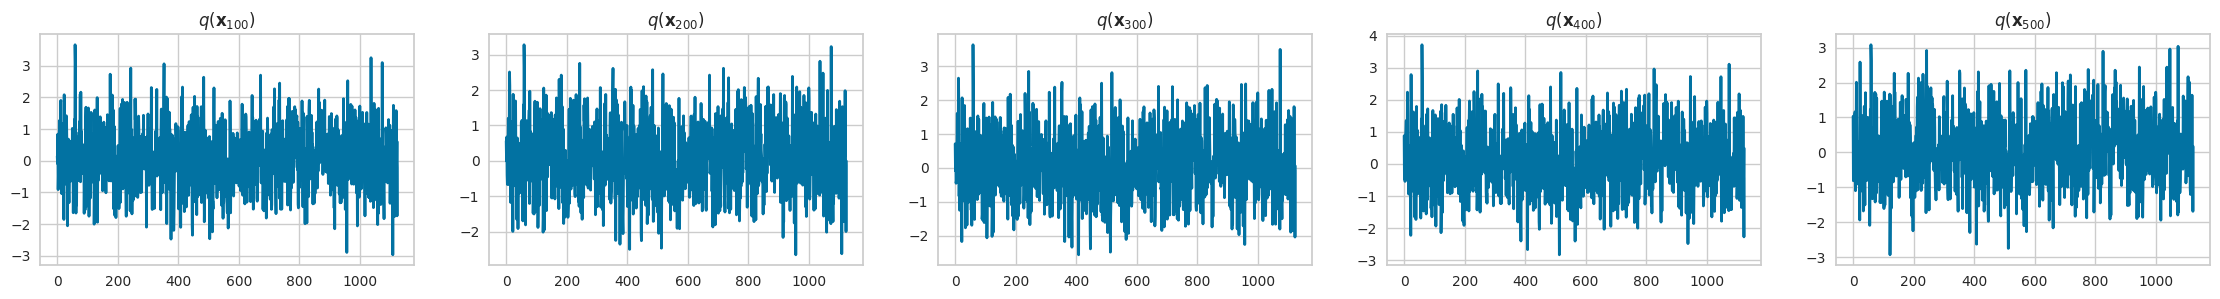

In [11]:
# Create ADAM optimizer over our model
model = ConditionalModel(n_steps).cuda(0)
model.load_state_dict(torch.load('diffusion/5_8_38.0_left'))
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Create EMA model
ema = EMA(0.9)
ema.register(model)
batch_size = 1125
loss_old = 500



params = {"Subject number":5,
          "Channel" : "C3",
          "Datasets":"BNCI2014001",
          "lr":0.0001,
          "n_steps" : n_steps ,
          "beta_schedule" : "sigmoid",
          'types' : "left"
          }

#run["parameters"] = params

x_seq = p_sample_loop(model, [1, dataset.shape[1]])
fig, axs = plt.subplots(1, 5, figsize=(28, 3))
for i in range(1, 6):
    cur_x = x_seq[i * 10 - 1].detach()
    axs[i-1].plot(cur_x[0, :].cpu(), linewidth=2);
    #axs[i].set_axis_off();
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

#run.stop()

In [24]:
cur_x = torch.randn([1, dataset.shape[1]]).cuda(0)
x_seq = [cur_x]
for i in reversed(range(499)):
    #print(i)
    cur_x = p_sample(model, cur_x, i)
    x_seq.append(cur_x)

In [13]:
cur_x = p_sample(model, torch.randn([1, dataset.shape[1]]).cuda(0), 499)

In [14]:
cur_x.shape

torch.Size([1, 1125])

In [15]:
cur_x

tensor([[-1.6837, -0.8641,  1.6812,  ..., -0.4410,  0.0103,  0.5375]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
def p_sample(model, x, t):
    model_mean, model_log_variance = p_mean_variance(model, x, t)
    eps = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
    return model_mean + eps * (0.5 * model_log_variance).exp()

def p_sample_loop(model, shape):
    cur_x = torch.randn(shape).cuda(0)
    x_seq = [cur_x]
    for i in reversed(range(n_steps - 1)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq
def compute_loss(model, x_0):
    # Sample continuous noise level
    batch_size = x_0.shape[0]
    continuous_sqrt_alpha_cumprod = sample_continuous_noise_level(batch_size)
    eps = torch.randn_like(x_0)
    # Diffuse the signal
    y_noisy = q_sample(x_0, continuous_sqrt_alpha_cumprod, eps)
    # Reconstruct the added noise
    eps_recon = model(y_noisy, continuous_sqrt_alpha_cumprod)
    #print(eps_recon.shape)
    loss = torch.nn.L1Loss()(eps_recon, eps)
    return loss

In [22]:
r_x = p_sample(model, cur_x, 498)

In [25]:
r_x.shape

torch.Size([1, 1125])

In [26]:
n_steps = 500
types_list = ['left','right','foot','tongue']

for subject in subject_list:
    for types in types_list:
        for i in range(23):
            x_seq = np.zeros((y_shape,x_shape[0],x_shape[1]))
            model = ConditionalModel(n_steps).cuda(0)
            model.load_state_dict(torch.load('diffusion/{0}_{1}_{2}'.format(subject,i,types)))
            cur_x = torch.randn([1, dataset.shape[1]]).cuda(0)
            cur_x = p_sample(model, cur_x, i)
            x_seq.append(cur_x)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [29]:
for i in range(22):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [ ]:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20